In [1]:
from google.colab import drive
# from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [3]:
# Load the HAM10000 dataset (update the path as needed)
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')


In [4]:
# Separate features and labels (assuming last column is the label)
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

In [5]:
# Rescale and reshape images
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)

# Resize images for EfficientNetB0
X_resized = tf.image.resize(X_reshaped, [96, 96]).numpy()

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

In [7]:

# Load EfficientNetB0 with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Fine-tune some layers
for layer in base_model.layers[-20:]:
    layer.trainable = True


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
])


In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
batch_size = 32
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=30
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.6262 - loss: 0.8698 - val_accuracy: 0.4980 - val_loss: 0.9397
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.7489 - loss: 0.7005 - val_accuracy: 0.5273 - val_loss: 0.9214
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.7791 - loss: 0.6545 - val_accuracy: 0.7390 - val_loss: 0.7362
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.8166 - loss: 0.5952 - val_accuracy: 0.8003 - val_loss: 0.5877
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.8151 - loss: 0.5698 - val_accuracy: 0.8336 - val_loss: 0.5478
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.8233 - loss: 0.5501 - val_accuracy: 0.8469 - val_loss: 0.5135
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.8419 - loss: 0.5216 - val_accuracy: 0.8609 - val_loss: 0.4850
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.8573 - loss: 0.4905 - val_accuracy: 0.852

In [11]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate and print classification report for test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, zero_division=0))



47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 318ms/step - accuracy: 0.9118 - loss: 0.3465
Test Accuracy: 90.35%
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 397ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       766
           1       0.92      0.88      0.90       737

    accuracy                           0.90      1503
   macro avg       0.90      0.90      0.90      1503
weighted avg       0.90      0.90      0.90      1503



In [12]:
# Generate and print classification report for test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, zero_division=0))

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 387ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       766
           1       0.92      0.88      0.90       737

    accuracy                           0.90      1503
   macro avg       0.90      0.90      0.90      1503
weighted avg       0.90      0.90      0.90      1503



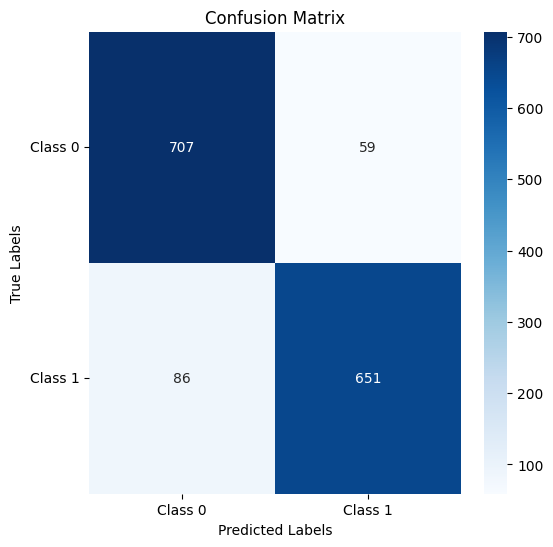

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are already defined
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with numbers inside the boxes
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'])
plt.yticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'], rotation=0)
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 322ms/step


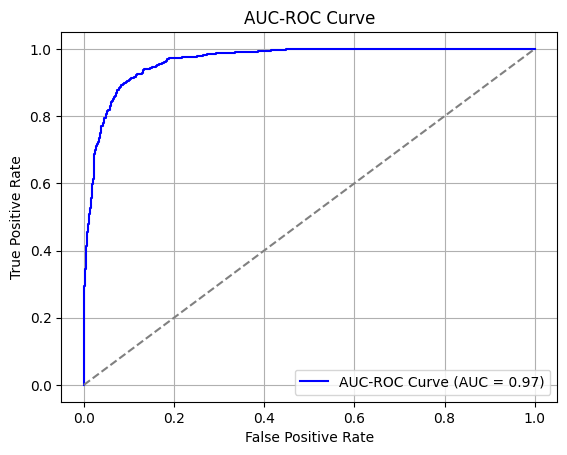

In [17]:
# Compute AUC-ROC
y_pred_prob = model.predict(X_test).ravel()
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot AUC-ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()
plt.grid(True)
plt.show()